In [14]:
import sqlite3
import pandas as pd
import numpy as np
from collections import defaultdict
from pylab import boxplot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Moneyball

## The Question
We want to understand how efficient teams have been historically at spending money and getting wins in return. In the case of Moneyball, one would expect that Oakland was not much more efficient than other teams in their spending before 2000, were much more efficient (they made a movie about it after all) between 2000 and 2005, and by then other teams may have caught up. Your job in this project is to see how this is reflected in the data we have.

## Part 1: Data Wrangling
### Problem 1
In this problem, I am using sqlite to retrieve the baseball data from lahman2014 data set. Then simply putting that data into a pandas dataframe to make data manipulation and calculations easier.

In [8]:
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

salary_query = "SELECT teamID, yearID, franchID, salary, W, G, ((W*1.0/G*1.0)*100.0) as winning_percentage FROM Teams NATURAL JOIN Salaries GROUP BY teamID, yearID"
count_query = "SELECT teamID, count(teamID) FROM Teams group by teamID"

team_salaries = pd.read_sql(salary_query, conn)
team_salaries.head()

,teamID,yearID,franchID,salary,W,G,winning_percentage
0,ANA,1997,ANA,1300000.0,84,162,51.851852
1,ANA,1998,ANA,225000.0,85,162,52.469136
2,ANA,1999,ANA,210000.0,70,162,43.209877
3,ANA,2000,ANA,222500.0,82,162,50.617284
4,ANA,2001,ANA,200500.0,75,162,46.296296


There are several missing data points as many of the older teams from the 1800s did not have salaries listed. I used a natural join and this will only return rows that match in both tables. Therefore, any team without a salary reported will not be listed in the output.

## Part 2: Exploratory Data Analysis
### Problem 2
In order to only have the years 1990 - 2014, I create a new dataframe from the previous one, selecting rows with years greater than 1989. Since the plot wants to see the salaries by year, I grouped the date by yearID and used a boxplot to show case summary statistics for each year.

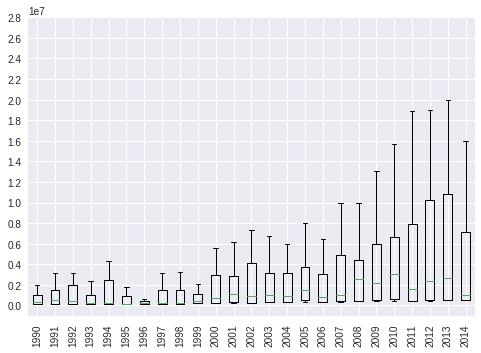

In [9]:
plots = []
years = []
sals = []
df = team_salaries.loc[team_salaries.yearID > 1989]

for a in df.groupby('yearID')['salary']:
    years.append(a[0])
    plots.append(a[1])
    
for a in range (0, 15):
    sals.append(a * 30000000/15)
fig, axes = plt.subplots()
plt.boxplot(plots)
axes.set_xticklabels(years, rotation = 'vertical')
axes.set_yticks(sals)
plt.show()

Question 1

Note* Graph does not show outliers

The distribution appears to be skewed left with the greatest salaries in 2013. This graph makes sense because the value of money always increases with time due to inflation. Also, it appears that there is a huge difference between the IQR of 2013 and all the years before 2000. The IQR for 2013 is nearly double or triple the ranges before 2000.

### Problem 3
Plotting the mean salary was rather simple, using the same method to groupby yearID as in the previous problem and then taking the mean. This plot shows a steady increase in mean salary over time with a rather steep and suprising dropoff in 2014. 

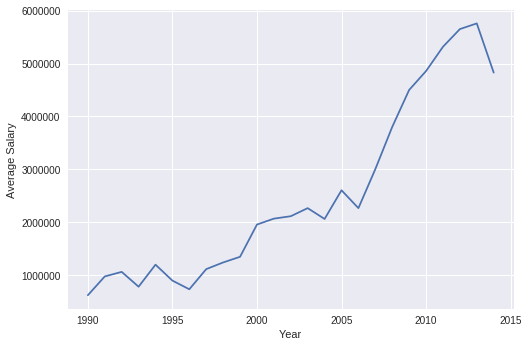

In [117]:
means = df.groupby('yearID')['salary'].mean()

plt.plot(means)
plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.show()

### Problem 4
In order to sepearte the data into 5 time periods, I used the pandas.cut method. Once the data was assigned a time period, I iterated through each time period and found the mean salary and winning perecentage of each team for that specific time period. This was accopmlished by using a groupby with teamID and then using the mean method.

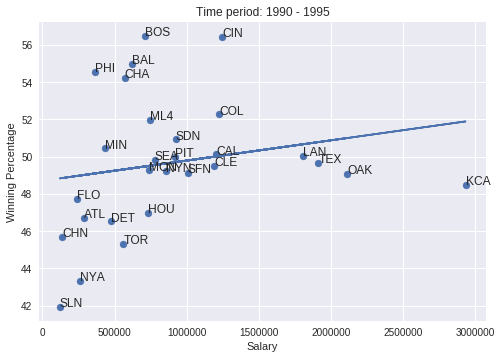

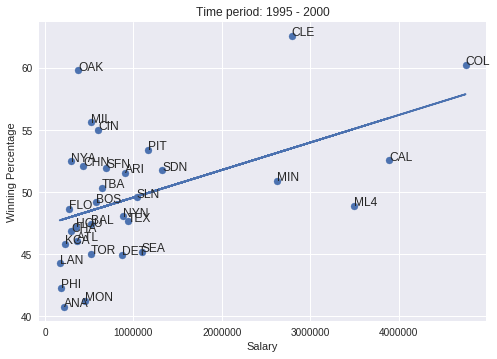

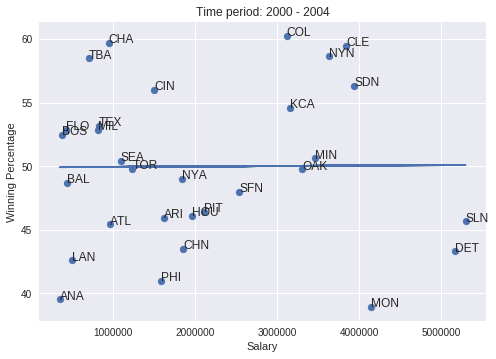

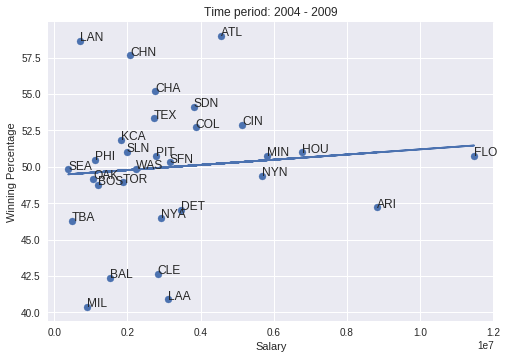

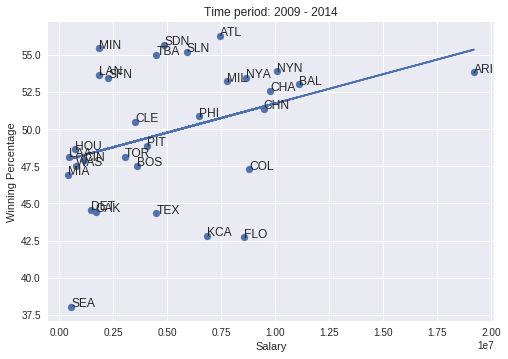

In [10]:
cats = pd.cut(df['yearID'], 5, labels = [1,2,3,4,5], retbins=True)

for i, group in df.groupby(cats[0]):
    x = []
    y = []
    labels = set()
    for team in group.teamID:
        labels.add(team)
    for row, g in group.groupby('teamID'):
        g = g.mean()
        x.append(g['salary'])
        y.append(g['winning_percentage'])
        
    fig, ax = plt.subplots()

    m, b = np.polyfit(x,y,1)
    x = np.array(x)
    y = np.array(y)
    plt.scatter(x,y)
    plt.plot(x, m*x + b)
    plt.title('Time period: {:.0f} - {:.0f}'.format(cats[1][i-1],cats[1][i]))
    plt.xlabel('Salary')
    plt.ylabel('Winning Percentage')
    for i,label in enumerate(labels):
        ax.annotate(label, xy=(x[i],y[i]), xytext=(x[i],y[i]))
    plt.show()

Question 2

Note* Time periods are rounded in titles of the graph.

The first, second and fith time periods indicated that teams spending more money had a signifcantly higher winning percentage than teams who spent less money on average. The other time periods did not show any real signifcant difference. The Philadelphia Phillies seem really good at paying for wins. For each time period, they are above the regression line and close to the top for winning percentage, but are either in the bottom fourth or bottom half of the salary.The Oakland A's are very similar to the Phillies but they are not able to get as a high a winning percentage.  

### Problem 5
Here I created a new column that represented the standardized salaries for every team for every year. This was calculated by taking the salary for each team for a specific year, subtracting the average salary for all teams for that specific year, and then finally dividing that value by the standard deviation of the average salary. 

In [11]:
newcol = []
for i,group in df.groupby('yearID'):
    avg_payroll = group.mean()['salary']
    std = group.std()['salary']
    for team in group.iterrows():
        newcol.append((team[1][3]-avg_payroll)/std)
        
df = df.copy()
df['std_salaries'] = newcol

### Problem 6
This is essentially the same as problem 4 except I am now plotting standardized salaries on the x-axis instead of salary.

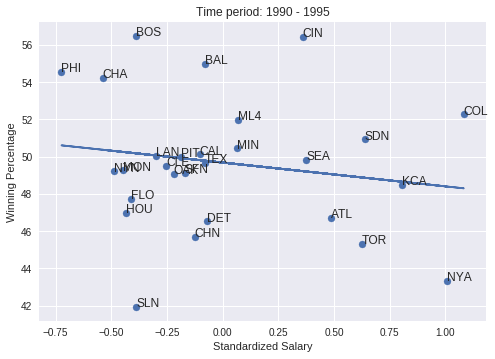

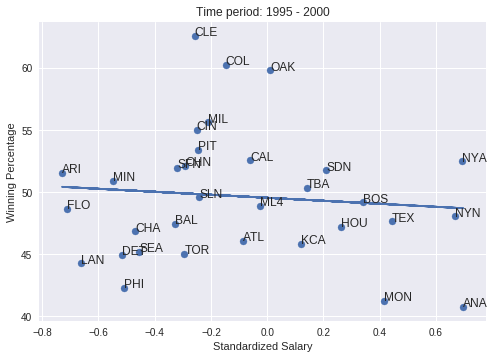

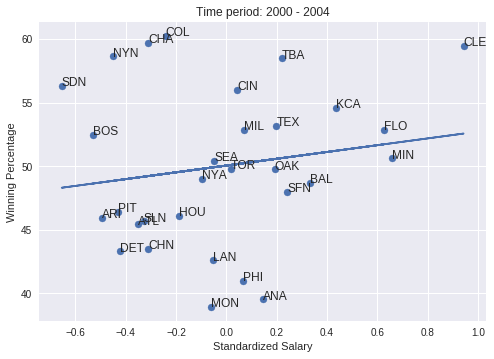

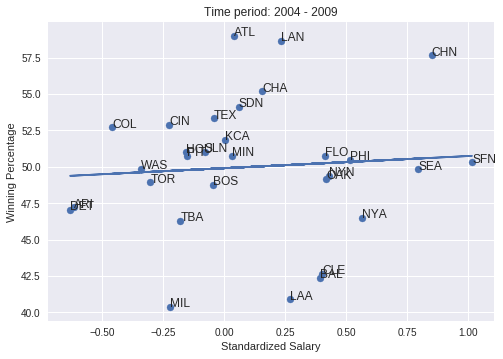

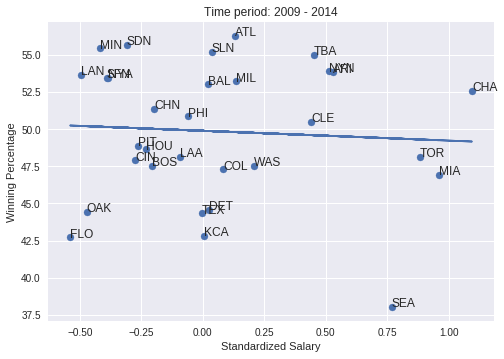

In [12]:
for i, group in df.groupby(cats[0]):
    x = []
    y = []
    labels = set()
    for team in group.teamID:
        labels.add(team)
    for row, g in group.groupby('teamID'):
        g = g.mean()
        x.append(g['std_salaries'])
        y.append(g['winning_percentage'])
        
    fig, ax = plt.subplots()

    m, b = np.polyfit(x,y,1)
    x = np.array(x)
    y = np.array(y)
    plt.scatter(x,y)
    plt.plot(x, m*x + b)
    plt.title('Time period: {:.0f} - {:.0f}'.format(cats[1][i-1],cats[1][i]))
    plt.xlabel('Standardized Salary')
    plt.ylabel('Winning Percentage')
    for i,label in enumerate(labels):
        ax.annotate(label, xy=(x[i],y[i]), xytext=(x[i],y[i]))
    plt.show()

Question 3

Note* Time periods are rounded in titles of the graph.

The plots shown above are more evenly spread out across the y-axis. This is indictiave of the data transformation that I made. Standardizing the data gives us a reference point about the mean and allows us to see which way the data point is relative to the mean (positive or negative).

### Problem 7
For this problem I made a plot of all the standardized salries vs winning percentage. The plot does not seem to have any sort of statistial significance since the regression line is horizontal. Also, the majority of the points are between -1 and 0 standard deviations from the mean

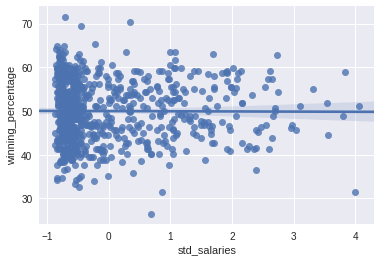

In [15]:
x = df['std_salaries']
y = df['winning_percentage']
sns.regplot(x, y)

### Problem 8
I created a new column in the dataframe called effiency. This is calculated by taking the winning perecentage and subtracting the excpected winning percentage. In order to create the graphs, I grouped by teamID and then retrieved the five teams to plot them in a line graph. 

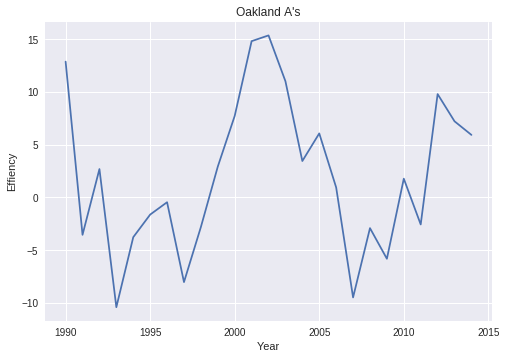

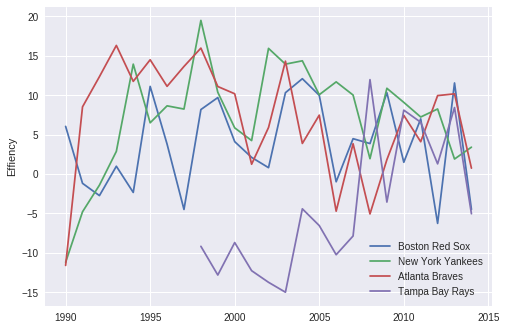

In [128]:
for i, row in df.iterrows():
    expected_wp = 50 + (2.5 * row['std_salaries'])
    newval = row['winning_percentage'] - expected_wp
    df.set_value(i,'effiency',newval)

teams = df.groupby('teamID')

x = teams.get_group('OAK')['yearID']
y1 = teams.get_group('OAK')['effiency']
y2 = teams.get_group('BOS')['effiency']
y3 = teams.get_group('NYA')['effiency']
y4 = teams.get_group('ATL')['effiency']
x2 = teams.get_group('TBA')['yearID']
y5 = teams.get_group('TBA')['effiency']

plt.title('''Oakland A's''')
plt.xlabel('Year')
plt.ylabel('Effiency')
plt.plot(x,y1)
plt.show()

plt.plot(x,y2, label='Boston Red Sox')
plt.plot(x,y3, label='New York Yankees')
plt.plot(x,y4, label='Atlanta Braves')
plt.plot(x2,y5, label='Tampa Bay Rays')

plt.ylabel('Effiency')
plt.legend(loc='lower right')
plt.show()


Question 4

The graph in this question is line graph with time on the x-axis and effiency on the y-axis. Looking at these plots its really easy to see where teams were being very effiecent at getting wins from spending less wins. Also, these plots show how over time became more or became less effiecent with the money they had to spend. Oakland's effiecncy was very good during the moneyball period (2000-2005). In the years leading up to 2000, we can see that the effiency was low, but shot up to it's peak in from about 2001-2002. After that it started to come back down. 